# Imports

In [1]:
# Imports
import os

from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR

from src.models.unet import Unet
from src.utils import (
    Preprocessor,
    plot_image_and_prediction,
    predict_image,
    predict_patch,
    seed_everyting,
    train,
    test,
    save,
    get_splits,
    get_datasets,
    get_dataloaders,
    get_device,
    loss,
)

# Global parameters

In [2]:
patch_size = 256
img_dir = "data/images"
model_dir = "models"
patch_dir = "data/patches"
gedi_dir = "data/gedi"
random_state = 42
batch_size = 12
num_workers = os.cpu_count()
learning_rate = 1e-2
epochs = 5
is_training = False
bins = list(range(0, 55, 5))
device = get_device()

seed_everyting(random_state)

INFO:root:Using mps device


# Preprocess labels and patches

In [3]:
# Create preprocessor
preprocessor = Preprocessor(img_dir, patch_dir, gedi_dir, patch_size)

# Run preprocessor
preprocessor.run()

# Get patches
patches = preprocessor.patches

INFO:root:Starting preprocessing...
INFO:root:Directories validated.
INFO:root:Images loaded.
INFO:root:Number of images: 48
INFO:root:GEDI data loaded.
INFO:root:Loaded existing patch info file. Skipping image processing.
INFO:root:Number of patches: 9234
INFO:root:Number of labels: 629074
INFO:root:Total number of patches: 9234


# Create datasets & dataloader

In [4]:
# Create splits
train_df, val_df, test_df = get_splits(patches)

# Create datasets
train_ds, val_ds, test_ds = get_datasets(
    train_df, val_df, test_df, f"{patch_dir}/{patch_size}"
)

# Create dataloaders
train_dl, val_dl, test_dl = get_dataloaders(
    train_ds, val_ds, test_ds, batch_size, num_workers
)

# Create & Train model

In [5]:
model = Unet().to(device)

# Create optimizer
optimizer = SGD(model.parameters(), learning_rate)

# Create scheduler
scheduler = CosineAnnealingLR(optimizer, epochs)

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    train(train_dl, model, loss, device, optimizer, scheduler)
    test(val_dl, model, loss, device)

INFO:root:Loading model u-efficientnet-b4


In [ ]:
# save(model, os.path.join(model_dir, f"{model.name}.pt"))

# Visualise results

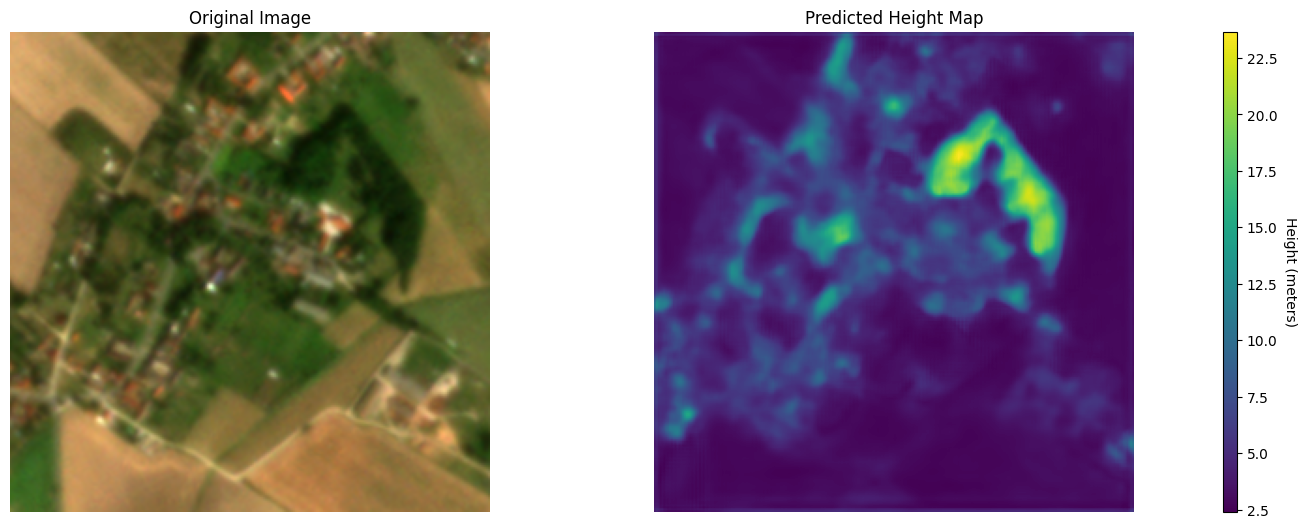

In [6]:
idx = 42
patch = test_ds[idx]
img, pred = predict_patch(model, patch, device)
plot_image_and_prediction(img, pred, 3)

In [7]:
image, prediction = predict_image(
    model, device, f"{img_dir}/L15-1059E-1348N.tif", patch_size
)

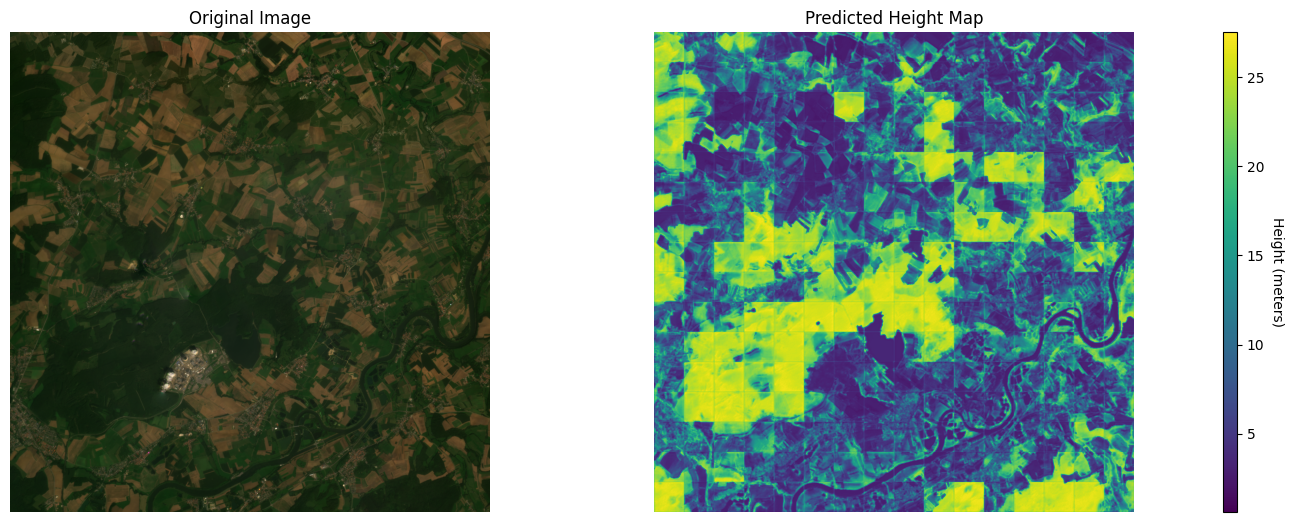

In [8]:
plot_image_and_prediction(image, prediction, 3)